In [ ]:
!git clone https://github.com/cbtn-data-science-ml/tensorflow-professional-developer.git

Cloning into 'tensorflow-professional-developer'...
remote: Enumerating objects: 266, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 266 (delta 13), reused 23 (delta 7), pack-reused 236 (from 1)
Receiving objects: 100% (266/266), 10.12 MiB | 8.02 MiB/s, done.
Resolving deltas: 100% (116/116), done.


In [ ]:
!pwd

/content


In [ ]:
%cd /content/tensorflow-professional-developer/

/content/tensorflow-professional-developer


In [ ]:
!wget https://raw.githubusercontent.com/cbtn-data-science-ml/tensorflow-professional-developer/main/model_utils.py
from model_utils import early_stopping_callback, model_checkpoint_callback, plot_loss_and_accuracy


--2024-11-20 15:48:29--  https://raw.githubusercontent.com/cbtn-data-science-ml/tensorflow-professional-developer/main/model_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2305 (2.3K) [text/plain]
Saving to: ‘model_utils.py.1’

model_utils.py.1    100%[===================>]   2.25K  --.-KB/s    in 0s      

2024-11-20 15:48:30 (35.1 MB/s) - ‘model_utils.py.1’ saved [2305/2305]



In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
import tensorflow_hub as hub
import pandas as pd
from sklearn.model_selection import train_test_split




# Load and preprocess data
train_path = 'nlp_disaster_tweets/train.csv'
test_path = 'nlp_disaster_tweets/test.csv'

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# Clean text function
def clean_text(text):
    text = text.lower()
    text = tf.strings.regex_replace(text, r"http\S+|www\S+|https\S+", "")
    text = tf.strings.regex_replace(text, r"<.*?>", "")
    text = tf.strings.regex_replace(text, r"[^a-z\s]", "")
    return text

train_df['clean_text'] = train_df['text'].apply(clean_text)
test_df['clean_text'] = test_df['text'].apply(clean_text)

# Split train and validation data
X_train, X_val, y_train, y_val = train_test_split(
    train_df['clean_text'].astype(str),
    train_df['target'].values,
    test_size=0.2,
    random_state=42
)

# Define the Universal Sentence Encoder layer
class USELayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(USELayer, self).__init__(**kwargs)
        self.encoder = hub.KerasLayer(
            "https://tfhub.dev/google/universal-sentence-encoder/4",
            trainable=False,
            name="USE"
        )

    def call(self, inputs):
        return self.encoder(inputs)

# Build the model using Functional API
input_text = Input(shape=(), dtype=tf.string, name="input_text")  # Input layer for strings
sentence_embeddings = USELayer()(input_text)  # Custom USELayer
x = Dense(256, activation="relu")(sentence_embeddings)  # Hidden dense layer
output = Dense(1, activation="sigmoid", name="output_layer")(x)  # Output layer for binary classification

# Build and compile the model
model = Model(inputs=input_text, outputs=output, name="Model_USE")
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)


In [ ]:

import numpy as np

# Convert the data to NumPy arrays
X_train_array = np.array(X_train, dtype=object)  # Specify dtype=object for string data
X_val_array = np.array(X_val, dtype=object)

# Train the model
history = model.fit(
    X_train_array,  # Use NumPy array format for X_train
    y_train,
    epochs=20,
    batch_size=16,
    validation_data=(X_val_array, y_val),  # Use NumPy array format for X_val
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint(filepath="best_model.keras", save_best_only=True)
    ]
)


# Display the model summary
model.summary()


Epoch 1/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.7203 - loss: 0.6288 - val_accuracy: 0.8076 - val_loss: 0.4645
Epoch 2/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.8099 - loss: 0.4455 - val_accuracy: 0.8109 - val_loss: 0.4295
Epoch 3/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.8161 - loss: 0.4171 - val_accuracy: 0.8148 - val_loss: 0.4211
Epoch 4/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.8208 - loss: 0.4045 - val_accuracy: 0.8181 - val_loss: 0.4179
Epoch 5/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.8174 - loss: 0.4069 - val_accuracy: 0.8214 - val_loss: 0.4160
Epoch 6/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8286 - loss: 0.3873 - val_accuracy: 0.8207 - val_loss: 0.4146
Epoch 7/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8236 - loss: 0.3917 - val_accuracy: 0.8234 - val_loss: 0.4142
Epoch 8/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.8336 - loss: 0.3855 - val_acc

Model: "Model_USE"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_text (InputLayer)              │ (None)                      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ use_layer (USELayer)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 394,757 (1.51 MB)

 Trainable params: 131,585 (514.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 263,172 (1.00 MB)

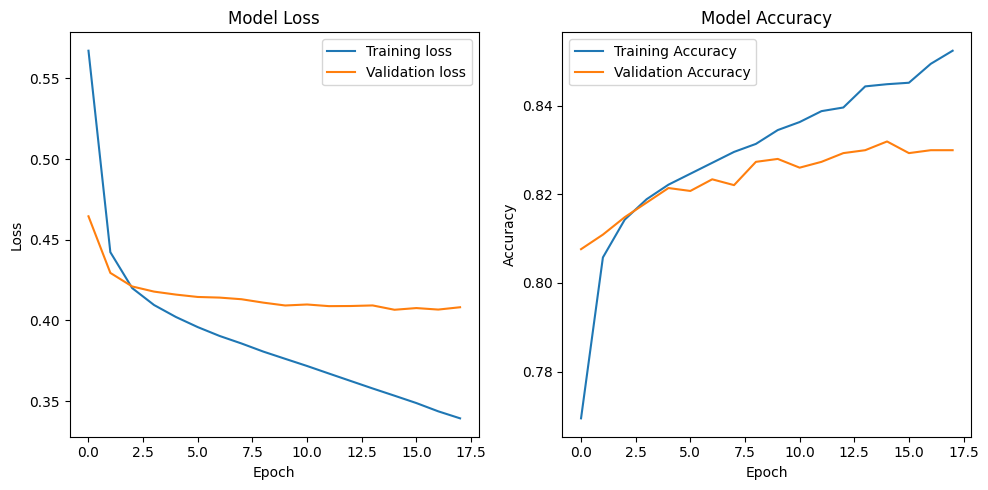

In [ ]:
plot_loss_and_accuracy(history)